# Imports

In [1]:
import os
import re

import emoji
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

pd.set_option('display.max_colwidth', 100)

# Read Data

In [2]:
df_full = pd.read_csv('./data/sampled_data.csv')

# Feature Engineering
Adding fulltext and engagement_score

In [3]:
def concatenate_fields(df, field_1='title', field_2='selftext'):
    df['fulltext'] = df[field_1] + ' ' + df[field_2]
    return df

df_full = concatenate_fields(df_full)

In [4]:
def add_engagement_score(df_orig):
    df = df_orig.copy()
    
    df['all_votes'] = df['score'] / df['upvote_ratio']
    df['engagement_score'] = df['all_votes'] + df['num_comments'] + df['num_crossposts']
    
    return df
    
df_full = add_engagement_score(df_full)

# Split Data into Training/Validation/Test Groups

In [5]:
def split_data(df_full, split=(0.7, 0.15, 0.15)):
    X_full = df_full[['id', 'author', 'created', 'retrieved', 'edited',
           'pinned', 'archived', 'locked', 'removed', 'deleted', 'is_self',
           'is_video', 'is_original_content', 'title', 'link_flair_text',
           'upvote_ratio',  'gilded', 'total_awards_received',
           'num_comments', 'num_crossposts', 'selftext', 'thumbnail', 'shortlink',
           'score', 'fulltext','file'
        ]]

    Y_full = df_full['engagement_score']

    X_train, X_t, y_train, Y_t = train_test_split(X_full,  Y_full, train_size=split[0], random_state=1)
    X_val, X_test, y_val, y_test = train_test_split(X_t,  Y_t, train_size=split[1]/(split[1]+split[2]), random_state=1)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_full)

In [6]:
df = pd.concat((X_train, y_train), axis=1)

# Examine Training Data for Data Cleaning

In [7]:
df.shape

(29630, 27)

In [8]:
df.isna().sum()

id                          0
author                      0
created                     0
retrieved                   0
edited                      0
pinned                      0
archived                    0
locked                      0
removed                     0
deleted                     0
is_self                     0
is_video                    0
is_original_content         0
title                       0
link_flair_text          9924
upvote_ratio                0
gilded                      0
total_awards_received       0
num_comments                0
num_crossposts              0
selftext                    0
thumbnail                   0
shortlink                   0
score                       0
fulltext                    0
file                        0
engagement_score            0
dtype: int64

In [9]:
df.shape

(29630, 27)

In [10]:
df.dropna(subset='score').shape

(29630, 27)

### Dropping Null fulltext values - Training Data

In [11]:
print(df.shape)
df = df.dropna(subset='fulltext')
print(df.shape)

(29630, 27)
(29630, 27)


### Dropping Null selftext values - Training Data

In [12]:
print(df.shape)
df = df.dropna(subset='selftext')
print(df.shape)

(29630, 27)
(29630, 27)


### Filling NA's for link_flair_text - Training Data

In [13]:
df[df['link_flair_text'].isna()].fillna({'link_flair_text':''}).iloc[:2]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink,score,fulltext,file,engagement_score
19474,n54ufv,SleepingManatee,2021-05-05 02:16:32,2021-05-05 08:28:19,2021-05-05 02:22:30,0,0,0,0,0,...,0,4,0,"A follow up to my recent post, which may be useful.\n\nSo, I discovered that I failed to include...",self,https://redd.it/n54ufv,2,"Apparently I’ve arrived (er, not quite) A follow up to my recent post, which may be useful.\n\nS...",financialindependence/,7.174603
37319,qlo6nc,JRick187,2021-11-03 06:07:20,2021-11-03 14:10:56,1970-01-01 00:00:00,0,0,0,0,0,...,0,2,0,"Been getting my feet wet over the last 9 months or so, I have generally been selling CSPs, put c...",self,https://redd.it/qlo6nc,1,"Selling strangles without margin? Been getting my feet wet over the last 9 months or so, I have ...",options/,3.000000


In [14]:
df.describe()

,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,score,engagement_score
count,29630.0,29630.0,29630.000000,29630.000000,29630.0,29630.0,29630.0,29630.000000,29630.000000,29630.000000,29630.000000,29630.000000,29630.000000,29630.000000,29630.000000
mean,0.0,0.0,0.001350,0.006446,0.0,1.0,0.0,0.019575,0.777608,0.019744,0.719845,68.476477,0.064057,83.709889,159.725938
std,0.0,0.0,0.036718,0.080030,0.0,0.0,0.0,0.138536,0.200417,0.212938,8.883516,1204.348030,0.495905,1034.766239,1866.935135
min,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.670000,0.000000,0.000000,3.000000,0.000000,1.000000,7.174603
50%,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.820000,0.000000,0.000000,8.000000,0.000000,5.000000,16.666667
75%,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.950000,0.000000,0.000000,21.000000,0.000000,18.000000,43.308404
max,0.0,0.0,1.000000,1.000000,0.0,1.0,0.0,1.000000,1.000000,11.000000,586.000000,96694.000000,30.000000,96770.000000,125386.625000


Remove the "Unnamed: 0" field

In [15]:
df.iloc[:2]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink,score,fulltext,file,engagement_score
41030,oixdah,TRAway0977,2021-07-12 18:33:28,2021-07-13 00:45:33,2021-07-12 19:04:23,0,0,0,0,0,...,0,22,0,"Hi everyone,\n\nI currently work IT for a steady company. Decent pay, great benefits covered by ...",self,https://redd.it/oixdah,0,"Higher salary vs benefits Hi everyone,\n\nI currently work IT for a steady company. Decent pay, ...",personalfinance/,22.000000
19474,n54ufv,SleepingManatee,2021-05-05 02:16:32,2021-05-05 08:28:19,2021-05-05 02:22:30,0,0,0,0,0,...,0,4,0,"A follow up to my recent post, which may be useful.\n\nSo, I discovered that I failed to include...",self,https://redd.it/n54ufv,2,"Apparently I’ve arrived (er, not quite) A follow up to my recent post, which may be useful.\n\nS...",financialindependence/,7.174603


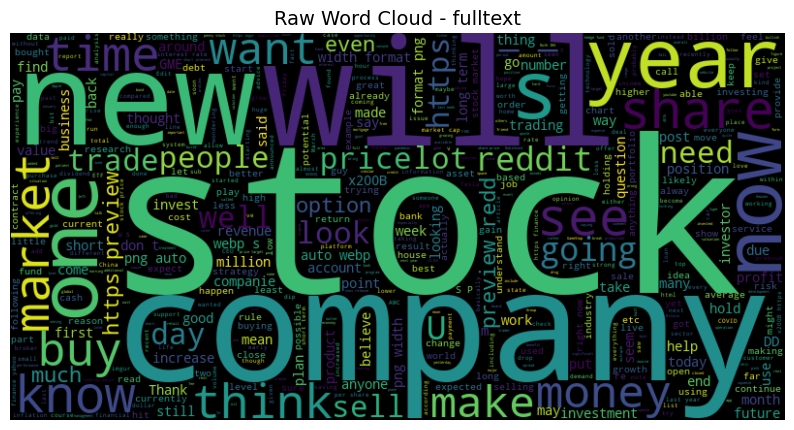

In [16]:
plt.figure(figsize=(10, 10))
words = " ".join(df['fulltext'])
wc1 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc1, interpolation='bilinear')
plt.title('Raw Word Cloud - fulltext', fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

### Reviewing unexpected terms, such as https, webp, pgn  - Training Data

Where are these words coming from?

In [17]:
search_terms = [r'https', r'webp','png']

The search terms are all part of url's. They will be removed.

In [18]:
df[df['fulltext'].apply(lambda x: any(pattern in x for pattern in search_terms))]['fulltext'].iloc[0]

'Have you increased or decreased your starting capital with penny stocks? Considering the great amount of gain porn on this subreddit I’d like to see if we can get some more realistic clarity on the situation here.\n\nEdit: I already notice a flaw in my poll. It should include some incremental s of trading duration. I might post another more comprehensive poll tomorrow after seeing how this particular one is received\n\n[View Poll](https://www.reddit.com/poll/lpbile)'

In [19]:
df[df['fulltext'].apply(lambda x: any(pattern in x for pattern in search_terms))]['fulltext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)).iloc[0]

'Have you increased or decreased your starting capital with penny stocks? Considering the great amount of gain porn on this subreddit I’d like to see if we can get some more realistic clarity on the situation here.\n\nEdit: I already notice a flaw in my poll. It should include some incremental s of trading duration. I might post another more comprehensive poll tomorrow after seeing how this particular one is received\n\n[View Poll](<url>)'

Remove URL's, and replace with "< url >"

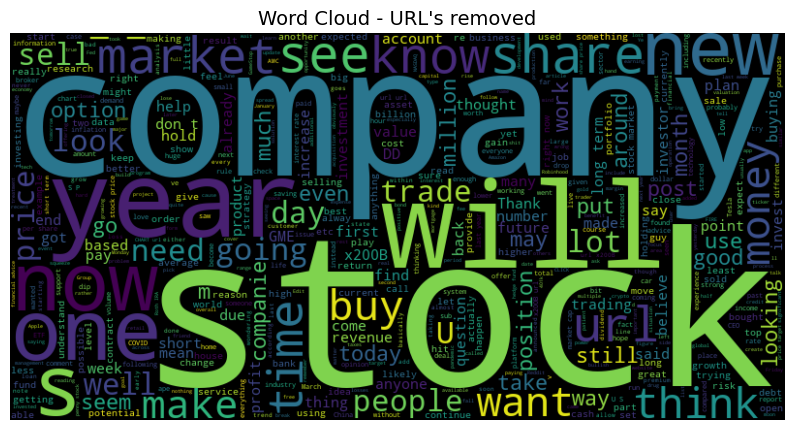

In [20]:
plt.figure(figsize=(10, 10))
words = " ".join( df['fulltext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)) )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - URL's removed", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

In [21]:
# Identifying x200b, which is zero width space
search_terms = ['x200']
zero_width_indexes = df['fulltext'].apply(lambda x: any(pattern in x for pattern in search_terms))
df[zero_width_indexes]['fulltext'].iloc[0][:1000]

'EURUSD Price is respecting this channel on the H4 timeframe and probably might come down to retest $1.20 support and also lower trendline. From there, scale down to 15min and look to enter.\n\n&#x200B;\n\nhttps://preview.redd.it/yl9koa1tneu61.png?width=2560&format=png&auto=webp&s=c99538770d3e2f3afa9c9578b299e614e4b140c6'

In [22]:
# Remove zero width spaces (x200B)
df[zero_width_indexes]['fulltext'].apply(lambda x: re.sub(r'x200B', '', x)).iloc[0][:1000]

'EURUSD Price is respecting this channel on the H4 timeframe and probably might come down to retest $1.20 support and also lower trendline. From there, scale down to 15min and look to enter.\n\n&#;\n\nhttps://preview.redd.it/yl9koa1tneu61.png?width=2560&format=png&auto=webp&s=c99538770d3e2f3afa9c9578b299e614e4b140c6'

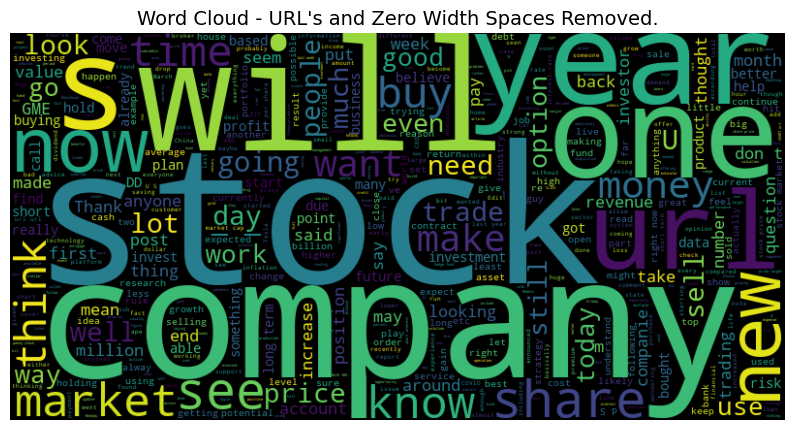

In [23]:
# Replace the HTTPS with <url> and remove zero width spaces (x200B) 
plt.figure(figsize=(10, 10))
words = " ".join( df['fulltext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)).apply(lambda x: re.sub(r'x200B', '', x)) )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - URL's and Zero Width Spaces Removed.", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

What are common selftext values, and how should they be handled?

In [24]:
df['fulltext'].value_counts().iloc[:5]

fulltext
Daily Discussion Thread  Discuss your picks and ideas below. This is also a great place for gain/loss pics. Keep things civil.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

This contains recurring discussion posts and self_text values of '[deleted]' which should be removed.

In [25]:
df.shape, df[df['fulltext']!='[deleted]'].shape

((29630, 27), (29630, 27))

### Discussion Posts - Training Data

Discussion posts will **not be removed** as many users interact with these posts.

In [26]:
text_frequency = df['fulltext'].value_counts().reset_index()
text_frequency = text_frequency[text_frequency['count']>3]
discussion_posts = text_frequency['fulltext'].tolist()

In [27]:
# Show one discussion post
discussion_posts[0]

'Daily Discussion Thread  Discuss your picks and ideas below. This is also a great place for gain/loss pics. Keep things civil.'

### Cleaning Data - Training Data

### Drop NA's - Training Data

In [28]:
df = df.dropna(subset='fulltext')

### Fill NA's - Training Data

In [29]:
df = df.fillna({'link_flair_text':''})

### Remove [deleted] selftext entries - Training Data

In [30]:
df[df['fulltext']==''].shape

(0, 27)

In [31]:
df[df['selftext']==''].shape

(0, 27)

In [32]:
df = df[df['fulltext']!='[deleted]']
df = df[df['selftext']!='[deleted]']

### Preprocess data and clean data - Training Data
We must remove excess HTML and other words.

In [33]:
unnamed_columns = [i for i in df.columns if 'Unnamed' in i]
df = df.drop(columns=unnamed_columns)

We must remove excess HTML and other words.

In [34]:
# def preprocessor(text):
#     try:
#         text = re.sub('<[^>]*>', '', text)
#         emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
#                                text)
#         text = (re.sub('[\W]+', ' ', text.lower()) +
#                 ' '.join(emoticons).replace('-', ''))
#     except Exception as e:
#         print(f'Exception when preprocessing.\n{e}')
#     finally:
#         return text

# from https://stackoverflow.com/questions/70304914/sentiment-analysis-python-tokenization
def cleaner(text):
    try:
        text = str(text).lower()
        text = re.sub(r'#(\w+)', r'<\1>', text)
        text = re.sub(r'\n', ' ', text) # Remove /n
        text = re.sub(r'@[A-Za-z0-9]+', '<user>', text) # Remove and replace @mention
        text = re.sub(r'RT\s+', '', text) # Remove RT
        text = re.sub(r'https?://\S+\b/?', '<url>', text) # Remove and replace links
        text = re.sub('x200B', '', text)
        text = re.sub('<[^>]*>', '', text)

        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                                   text)
        text = (re.sub('[\W]+', ' ', text) + ' '.join(emoticons).replace('-', ''))
    except Exception as e:
        print(f'Exception when preprocessing.\n{e}')
    finally:
        return text

def remove_urls(text):
    url_pattern = re.compile(r'http[s]?://\S+')
    return url_pattern.sub('', text)

def drop_unnamed_columns(df_orig):
    df = df_orig.copy()
    unnamed_columns = [i for i in df.columns if 'Unnamed' in i]
    df = df_full.drop(columns=unnamed_columns)
    return df

In [35]:
df['fulltext'] = df['fulltext'].apply(cleaner)

In [36]:
df['selftext'] = df['selftext'].apply(cleaner)

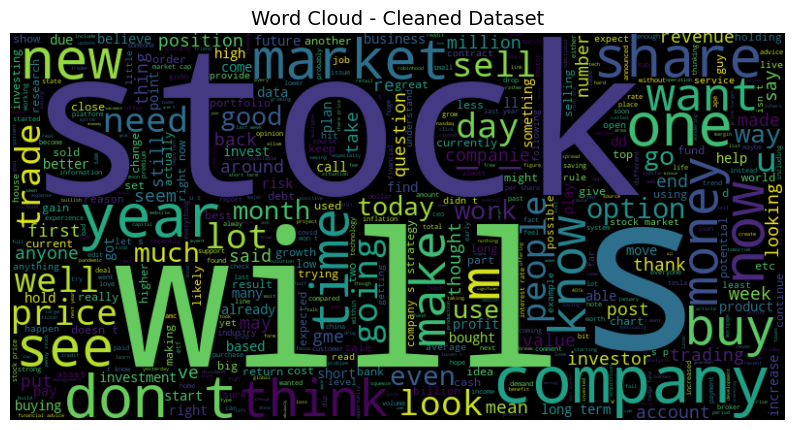

In [37]:
# Replace the HTTPS with <url> and remove zero width spaces (x200B) 
plt.figure(figsize=(10, 10))
words = " ".join( df['fulltext'] )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - Cleaned Dataset", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

### Standardizing Numeric Fields - Training Data

### Examine Numeric Fields - Training Data

In [38]:
numeric_columns = df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index.values
df[numeric_columns]

,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,score,engagement_score
41030,0,0,0,0,0,1,0,0,0.40,0,0,22,0,0,22.000000
19474,0,0,0,0,0,1,0,0,0.63,0,0,4,0,2,7.174603
1823,0,0,0,0,0,1,0,0,0.83,0,0,3,0,7,11.433735
3484,0,0,0,0,0,1,0,0,0.84,0,0,48,0,13,63.476190
37319,0,0,0,0,0,1,0,0,1.00,0,0,2,0,1,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7813,0,0,0,0,0,1,0,0,0.95,0,6,277,0,454,754.894737
32511,0,0,0,0,0,1,0,0,0.66,0,0,10,0,13,29.696970
5192,0,0,0,0,0,1,0,0,0.94,0,0,3,0,45,50.872340
12172,0,0,0,0,0,1,0,0,1.00,0,0,5,0,1,6.000000


### Scale Numeric Fields - Training Data

In [39]:
scaling_fields=['upvote_ratio','score','gilded','total_awards_received','num_comments','num_crossposts', 'engagement_score']

non_scaling_fields = [i for i in df.columns if i not in scaling_fields]

In [40]:
scaler = StandardScaler()

# Scale training data for examination
df_scaled_values = scaler.fit_transform(df[scaling_fields].values)

df_scaled = pd.DataFrame(df_scaled_values, columns=scaling_fields)

In [41]:
df_std = pd.concat((df[non_scaling_fields].reset_index(drop=True), df_scaled), axis=1)

In [42]:
df_std.iloc[1:3]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,shortlink,fulltext,file,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,engagement_score
1,n54ufv,SleepingManatee,2021-05-05 02:16:32,2021-05-05 08:28:19,2021-05-05 02:22:30,0,0,0,0,0,...,https://redd.it/n54ufv,apparently i ve arrived er not quite a follow up to my recent post which may be useful so i disc...,financialindependence/,-0.736517,-0.078966,-0.092721,-0.081033,-0.053537,-0.129173,-0.081714
2,pyh60e,cocodollxo,2021-09-30 10:40:48,2021-09-30 17:12:58,1970-01-01 00:00:00,0,0,0,0,0,...,https://redd.it/pyh60e,trading from australia strategies hi just curious to hear from anyone from aus nz and what strat...,forex/,0.261421,-0.074134,-0.092721,-0.081033,-0.054368,-0.129173,-0.079432


# Full Dataset Cleaning and Training/Validation/Test Assignments

Writes final file for models

## Decisions:
 * Clean NA's
 * Clean selftext data 
    * brackets
    * URL's
 * Empty rows on the "score" column
 * Dot not remove discussion posts.

In [43]:
df_full = df_full.dropna(subset=['fulltext','selftext'])

In [44]:
df_full = df_full.fillna({'link_flair_text':''})

In [45]:
df_full = df_full[df_full['fulltext']!='[deleted]']

In [46]:
df_full = df_full[df_full['selftext']!='[deleted]']

### Clean and Preprocess Data

In [47]:
df_full['fulltext'] = df_full['fulltext'].apply(cleaner)

In [48]:
df_full['selftext'] = df_full['selftext'].apply(cleaner)

### Drop Columns containing "Unnamed"

In [49]:
df_full = drop_unnamed_columns(df_full)

### Drop Empty selftext and fulltext

In [50]:
def drop_empty_column_records(df_orig, column):
    df = df_orig.copy()
    return df[df[column]!='']

In [51]:
df_full = drop_empty_column_records(df_full, 'selftext')
df_full = drop_empty_column_records(df_full, 'fulltext')

### Scale Numeric Fields

In [52]:
def scale_numeric_fields(scaler, df, df_train, scaling_fields):
    non_scaling_fields = [i for i in df.columns if i not in scaling_fields]

    scaler.fit(df_train[scaling_fields].values)
    
    df_scaled_values = scaler.transform(df[scaling_fields].values)
    df_scaled = pd.DataFrame(df_scaled_values, columns=scaling_fields)
    df_scaled = df_scaled.add_suffix('_std', axis=1)

    df_std = pd.concat((df.reset_index(drop=True), df_scaled), axis=1)
    
    return df_std

In [53]:
scaling_fields=['upvote_ratio','score','gilded','total_awards_received','num_comments','num_crossposts','engagement_score']

scaler = StandardScaler()

df_full = scale_numeric_fields(scaler, df_full, df, scaling_fields)

In [54]:
df_full.iloc[:2]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,fulltext,all_votes,engagement_score,upvote_ratio_std,score_std,gilded_std,total_awards_received_std,num_comments_std,num_crossposts_std,engagement_score_std
0,ocfjpi,Mortem_Nocte,2021-07-02 18:00:47,2021-07-03 01:23:50,1970-01-01 00:00:00,0,0,0,0,0,...,where to find these historical data i was away with trading for the past few months due to work ...,2.000000,6.000000,1.109668,-0.078966,-0.092721,-0.081033,-0.053537,-0.129173,-0.082343
1,l24m52,BenjaminWoody1,2021-01-21 18:40:08,2021-02-03 21:16:42,1970-01-01 00:00:00,0,0,0,0,0,...,question about nga upon closing of the proposed business combination a wholly owned subsidiary o...,3.703704,7.703704,0.161627,-0.078000,-0.092721,-0.081033,-0.053537,-0.129173,-0.081430


### Split Data into Train, Validation, Test sets

In [55]:
def split_data(df_full, split=(0.7, 0.15, 0.15)):
    split = (0.7, 0.15, 0.15) # --> to be discussed with team
    X_full = df_full[[
        'id', 'author', 'created', 'retrieved', 'edited',
        'pinned', 'archived', 'locked', 'removed', 'deleted', 'is_self',
        'is_video', 'is_original_content', 'title', 'link_flair_text',
        'upvote_ratio',  'gilded', 'total_awards_received', 'file',
        'num_comments', 'num_crossposts', 'selftext', 'fulltext',
        'thumbnail', 'shortlink', 'upvote_ratio_std', 'score_std',
        'gilded_std', 'total_awards_received_std', 'num_comments_std',
        'num_crossposts_std','engagement_score'
    ]]

    Y_full = df_full['engagement_score_std']

    X_train, X_t, y_train, Y_t = train_test_split(X_full,  Y_full, train_size=split[0], random_state=1)
    X_val, X_test, y_val, y_test = train_test_split(X_t,  Y_t, train_size=split[1]/(split[1]+split[2]), random_state=1)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_full)

In [56]:
X_train.to_csv('./data/final/X_train.csv', index=False)
y_train.to_csv('./data/final/y_train.csv', index=False)
X_val.to_csv('./data/final/X_val.csv', index=False)
y_val.to_csv('./data/final/y_val.csv', index=False)
X_test.to_csv('./data/final/X_test.csv', index=False)
y_test.to_csv('./data/final/y_test.csv', index=False)